In [118]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy.linalg import hankel

params = {}
params['embedding_dimension'] = 10
params['partial_measurement'] = 7
params['latent_dim'] = 10

In [119]:
with open('Results/final_output.pkl', 'rb') as f:
    results = pickle.load(f)

X_ori = results['x'].cpu().detach().numpy()
dx_ori = results['dx'].cpu().detach().numpy()
z = results['z'].cpu().detach().numpy()
sindy_coeff = results['sindy_coefficients'].cpu().detach().numpy()
Theta = results['Theta'].cpu().detach().numpy()

measured_index = [i*params['embedding_dimension'] for i in range(params['partial_measurement'])]
X_ori = X_ori[:, measured_index]
dx_ori = dx_ori[:, measured_index]

In [120]:
train_loss = np.load("Results/train_loss.npy")
val_loss = np.load("Results/val_loss.npy")
refine_loss = np.load("Results/refine_loss.npy")
refine_val_loss = np.load("Results/refine_val_loss.npy")

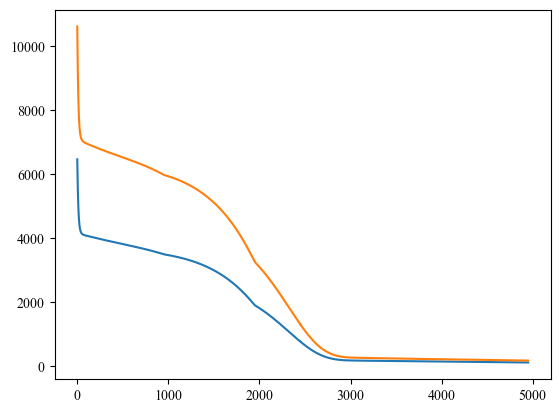

In [121]:
plt.plot(train_loss[50:])
plt.plot(val_loss[50:])

In [122]:
# plt.plot(refine_loss)
# plt.plot(refine_val_loss)

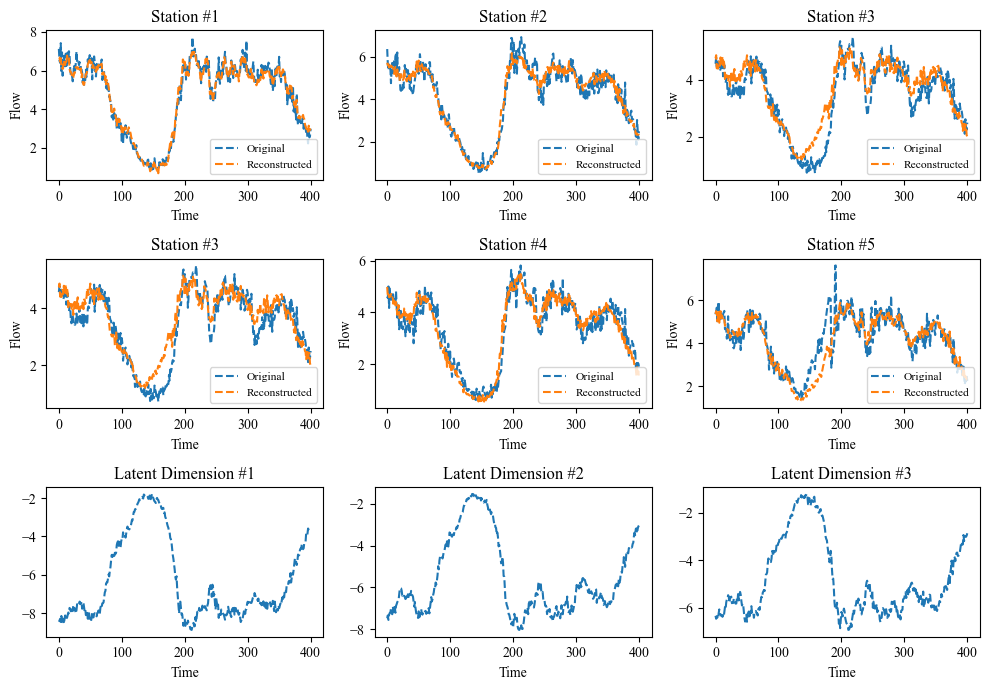

In [123]:
# Create a figure with 5 subplots (one for each column)
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 7))

# Plot each column in a separate subplot
for row in range(2):
    for col in range(3):
        axs[row, col].plot(X_ori[:, row*2 + col], "--", label = 'Original')
        axs[row, col].plot(z[:, row*2 + col], "--", label = 'Reconstructed')
        axs[row, col].set_title(f'Station #{(row*2 + col)+1}')
        axs[row, col].set_xlabel('Time')
        axs[row, col].set_ylabel('Flow')
        axs[row, col].legend(loc='lower right', fontsize='small')

for col in range(3):
    axs[2,col].plot(z[:,-(col+1)], "--")
    axs[2, col].set_title(f'Latent Dimension #{col+1}')
    axs[2, col].set_xlabel('Time')
    #axs[2, col].set_ylabel('Flow')
    #axs[2, col].legend(loc='lower right', fontsize='small')

# Show the figure
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/Ori_Recon_Plot.png")

In [124]:
dz_predict = results['dz_predict'].cpu().detach().numpy()
dz = results['dz'].cpu().detach().numpy()

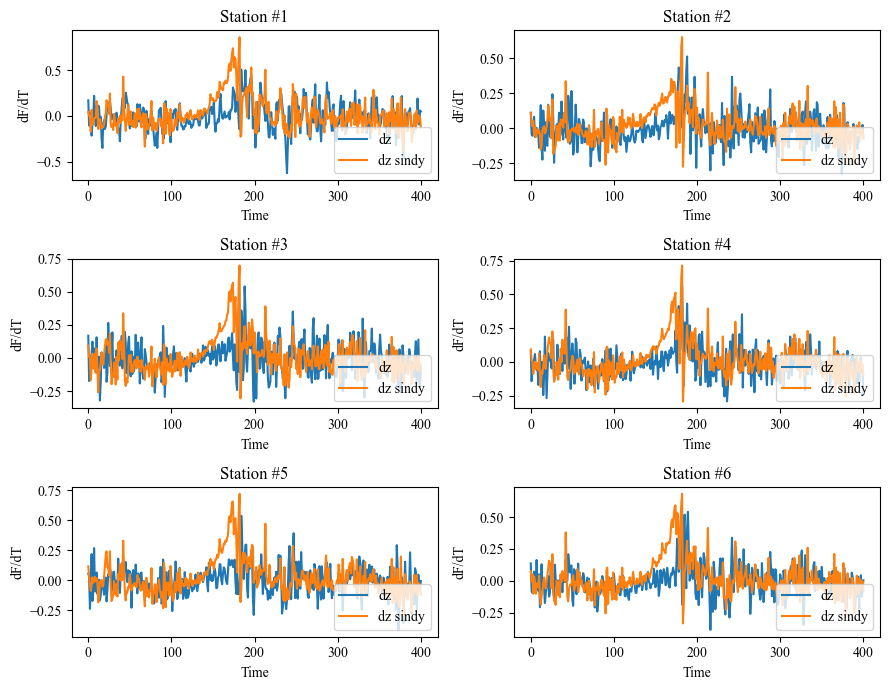

In [125]:
# Create a figure with 5 subplots (one for each column)
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 7))

# Plot each column in a separate subplot
for row in range(3):
    for col in range(2):
        #axs[row, col].plot(dx_ori[:, row*2 + col], label = 'dx')
        axs[row, col].plot(dz[:, row*2 + col], label = 'dz')
        axs[row, col].plot(dz_predict[:, row*2 + col], label = 'dz sindy')
        axs[row, col].set_title(f'Station #{(row*2 + col)+1}')
        axs[row, col].set_xlabel('Time')
        axs[row, col].set_ylabel('dF/dT')
        axs[row, col].legend(loc='lower right', fontsize='medium')

# Show the figure
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
#fig.savefig("Figures/Ori_Recon_Plot.png")

In [201]:
#Simulate data with discovered governing equations
total_sim_timestep = 401
total_pred_step = 1
s = (total_sim_timestep+1, 10)
sim_result = np.zeros(s)

In [202]:
from sindy_utils import sindy_library

In [203]:
for t in range(0,total_sim_timestep, total_pred_step+1):
    z_init = z[t,:].reshape(1,-1)
    sim_result[t,:] = z_init
    for i in range(total_pred_step):
        Theta_curr = sindy_library(z_init,2,False)
        dz_curr = np.matmul(Theta_curr,sindy_coeff)
        z_new = z_init + dz_curr
        sim_result[t+i+1,:] = z_new
        z_init = np.array(z_new)

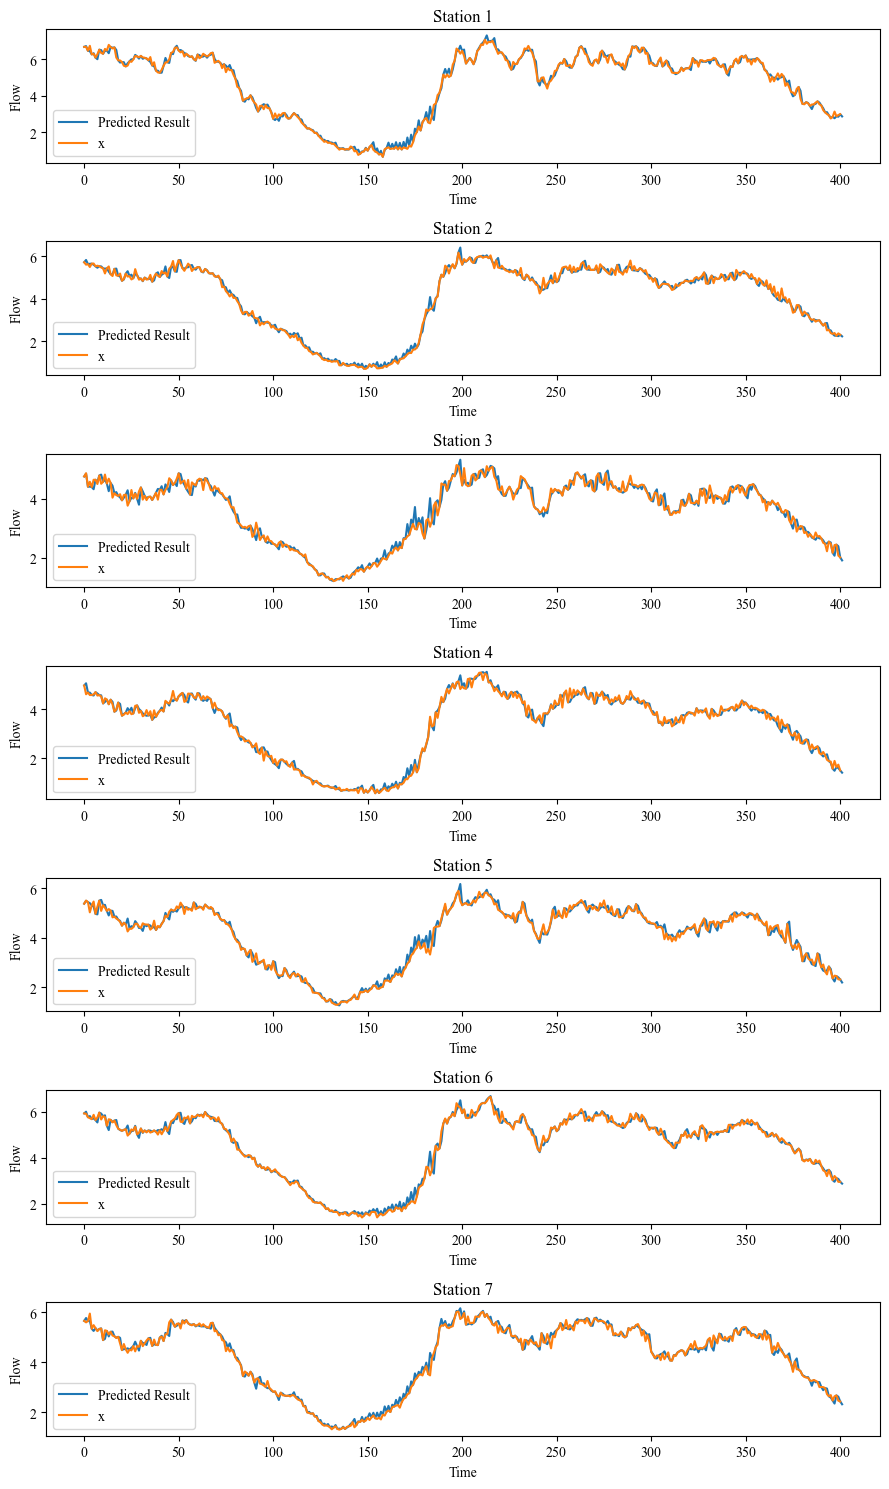

In [204]:
fig, axs = plt.subplots(nrows=X_ori.shape[1], ncols=1, figsize=(9, 15))

# Plot each column in a separate subplot
for i in range(X_ori.shape[1]):
    axs[i].plot(sim_result[:, i], label = 'Predicted Result')
    axs[i].plot(z[:,i], label = 'x')
    axs[i].legend()

# Add titles and axis labels to the subplots
for i, ax in enumerate(axs):
    ax.set_title(f'Station {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Flow')

# Show the figure
plt.tight_layout()
plt.show()

# Phase Plane

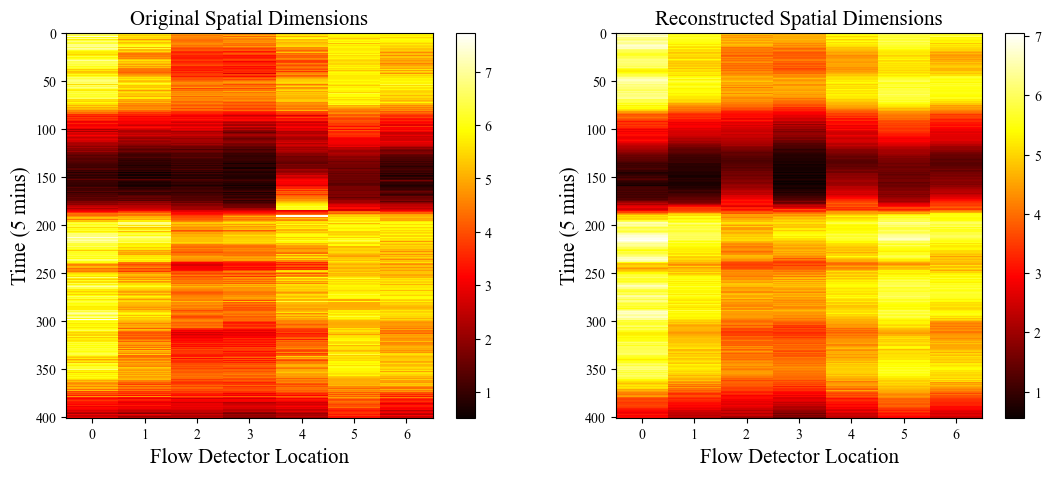

In [205]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
fig1 = axs[0].imshow(X_ori, cmap='hot', interpolation='nearest',aspect='auto')
plt.colorbar(fig1, ax = axs[0])
axs[0].set_xlabel('Flow Detector Location', fontsize = 15)
axs[0].set_ylabel('Time (5 mins)', fontsize = 15)
axs[0].set_title('Original Spatial Dimensions', fontsize = 15)

fig2 = axs[1].imshow(z[:,:params['partial_measurement']], cmap='hot', interpolation='nearest',aspect='auto')
plt.colorbar(fig2, ax = axs[1])
axs[1].set_xlabel('Flow Detector Location', fontsize = 15)
axs[1].set_ylabel('Time (5 mins)', fontsize = 15)
axs[1].set_title('Reconstructed Spatial Dimensions', fontsize = 15)
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/x_z_heatmap.png")

In [206]:
import random
indices = range(7)
index_pair = []
for i in range(7):
    for j in range(i+1, 7):
        index_pair.append((indices[i], indices[j]))
index_pair = random.sample(index_pair, 6)

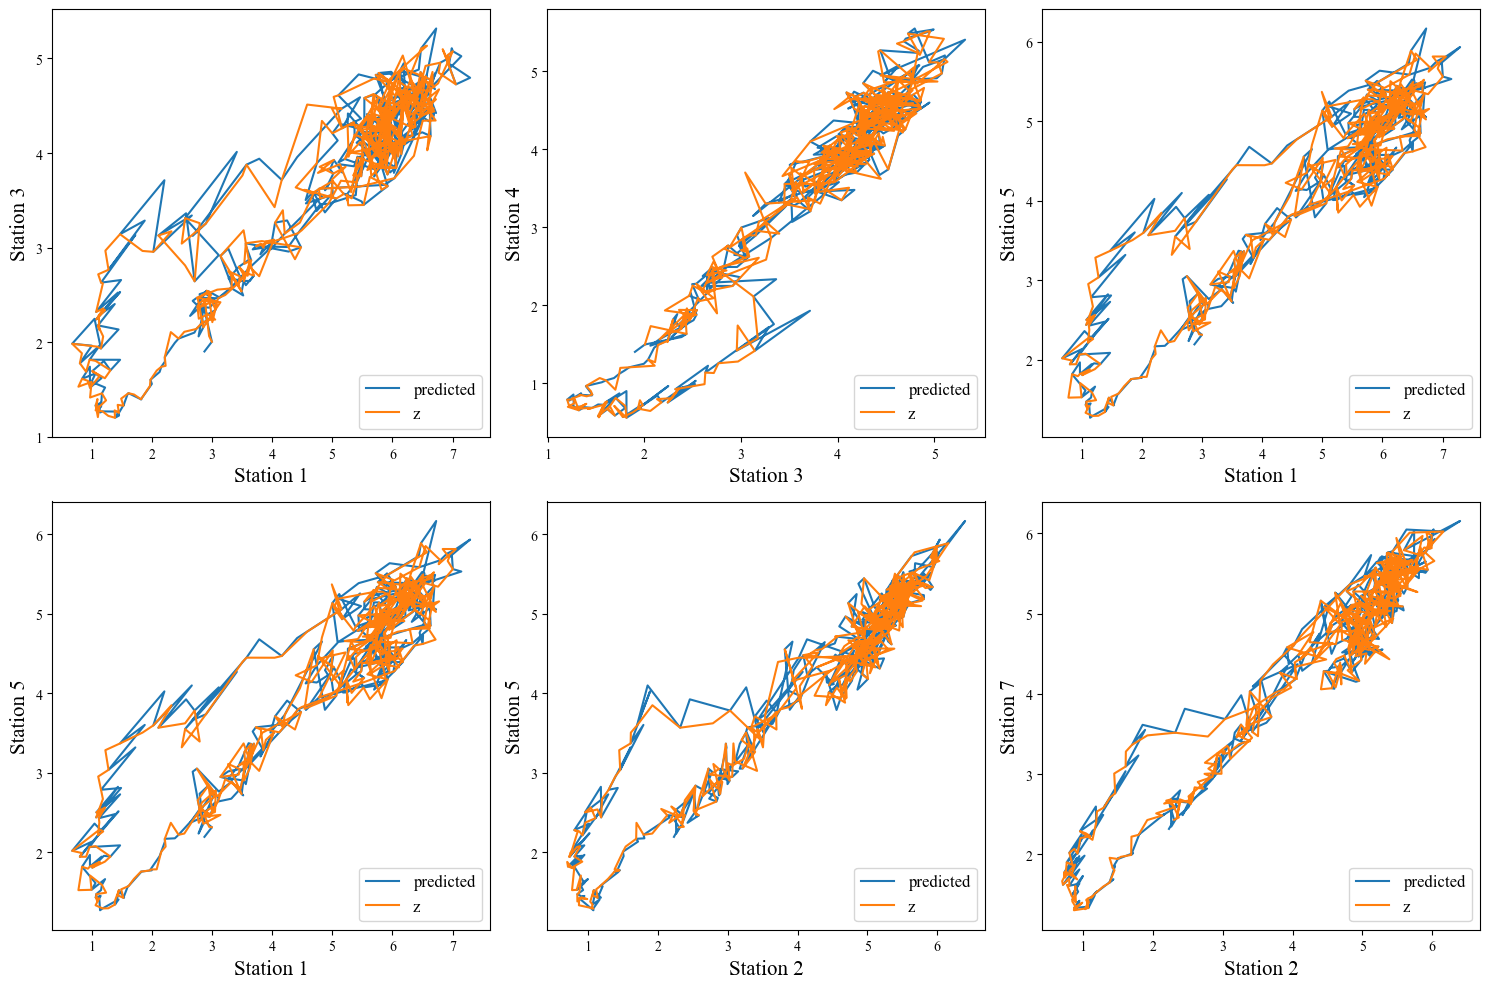

In [207]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for row in range(2):
    for col in range(3):
        index1 = index_pair[row*2 + col][0]
        index2 = index_pair[row*2 + col][1]
        #axs[row, col].plot(X_ori[:,index1], X_ori[:,index2], linewidth = 1, label = 'Ori Dim')
        axs[row, col].plot(sim_result[:,index1], sim_result[:,index2], label = 'predicted')
        axs[row, col].plot(z[:,index1], z[:,index2], label = 'z')
        axs[row, col].legend(loc='lower right', fontsize='large')
        axs[row, col].set_xlabel(f'Station {index1 + 1}', fontsize = 15)
        axs[row, col].set_ylabel(f'Station {index2 + 1}', fontsize = 15)
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/predicted_and_z_phase.png")

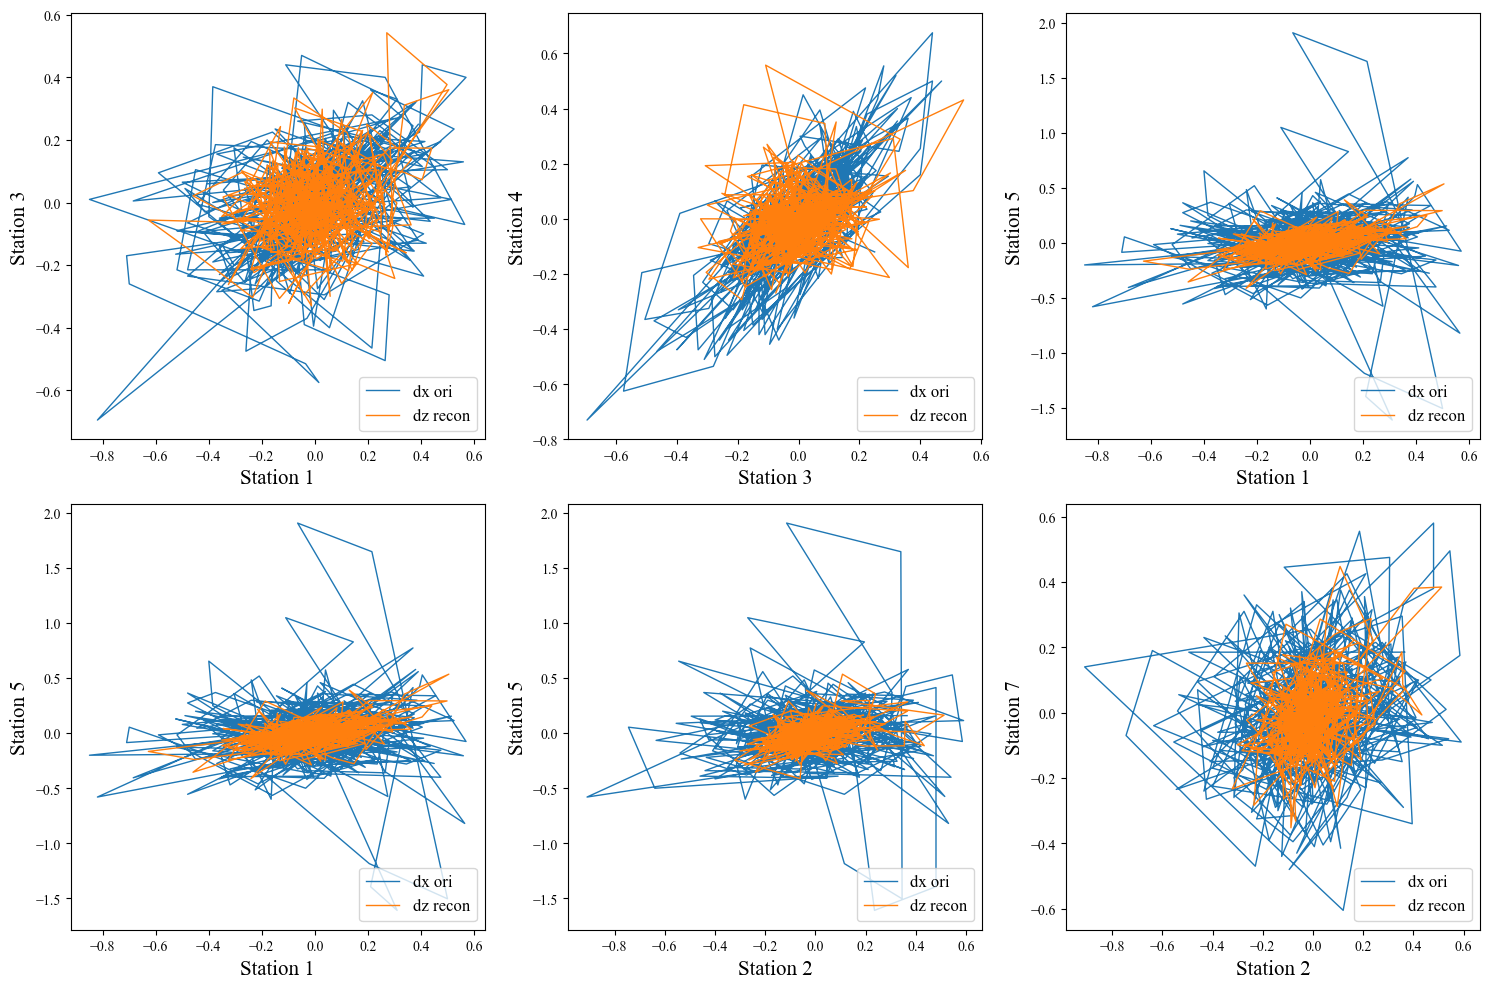

In [216]:

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for row in range(2):
    for col in range(3):
        index1 = index_pair[row*2 + col][0]
        index2 = index_pair[row*2 + col][1]
        axs[row, col].plot(dx_ori[:,index1], dx_ori[:,index2], linewidth = 1, label = 'dx ori')
        axs[row, col].plot(dz[:,index1], dz[:,index2], linewidth = 1, label = 'dz recon')
        axs[row, col].legend(loc='lower right', fontsize='large')
        axs[row, col].set_xlabel(f'Station {index1 + 1}', fontsize = 15)
        axs[row, col].set_ylabel(f'Station {index2 + 1}', fontsize = 15)

plt.tight_layout()